### AST 5731 
#### Group 1 - Project 1
#### Group Members: 

Style Notes (delete this cell prior to submission):
I figured we can use '###' for sections in markdown, then '####' if we want subsections (in which case we would probably do x.y formatting for the subsections). It might be tidier if we have markdown cells then code in each section, but we could also alternate between the two if people think that would be better

 ##### Contents
 1.   [Introduction](#introduction)
 2.   [Data](#data)  
    2.1 [Importing Data](#importing-data)    
   2.2 [Data Processing](#processing)
 3.   [Analysis](#analysis)   
    3.1 [Sensitivity Analysis](#senstivity)
 4.   [Results](#results)
 5.   [Discussion](#discussion)

### 1. Introduction 
<a id='introduction'></a>

Discussion of the problem and the goals of the project/ the questions we are trying to answer.


We will: 
1. Normalize the PDCSAP Flux data
2. Calculate the average flux over time
3. Determine the time range for each of the 14 transits
4. Calculate the time and depth for each transit

We will then run a Bayesian analysis on the transit depth data

### 2. Data
<a id='data'></a>

Description of the data and how it was obtained (talk about TESS briefly I guess)

Note: Our project was run on python 3.9.13, and an environment package detailing the versions for all packages used can be found [here](https://github.com/tylerbarna/AST5731-Group1/blob/main/environment.yml).

Importing packages used for project:

In [7]:
import csv
import dis
import inspect
import os
import sys
import time


import astropy
import astroquery
import eleanor ## alternative for TESS data analysis
import lightkurve as lk ## for importing and manipulating TESS data
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from lightkurve import search_targetpixelfile

from sklearn import preprocessing as pp

from scipy import linalg as la
from scipy import optimize
from scipy import integrate

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom

from IPython.display import display_html
from IPython.display import Image

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

While it is possible to search for and import data directly from an online database using the lightkurve package, we found this unprocessed data to be more difficult to work with, as the lighkurve method does not filter data particularly well. Instead, we opted to use data from MAST, which was processed by the TESS Science Office to reduce outliers caused by instrumental effects and the orbit of TESS. 

In [2]:
## read in data using astropy.io.fits 
fits_file = fits.open('./data/lc.fits')
fits_file.info()
print()

## read in the light curve data as a pandas dataframe
df = pd.DataFrame(fits_file[1].data)
df.info()


Filename: ./data/lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   18231R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18231 entries, 0 to 18230
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TIME             17457 non-null  float64
 1   TIMECORR         18231 non-null  float32
 2   CADENCENO        18231 non-null  int32  
 3   SAP_FLUX         17411 non-null  float32
 4   SAP_FLUX_ERR     17411 non-null  float32
 5   SAP_BKG          17411 non-null  float32
 6   SAP_BKG_ERR      17411 non-null  float32
 7   PDCSAP_FLUX      16855 non-null  float32
 8   PDCSAP_FLUX_ERR  16855 non-null  float32
 9   QUALITY          18231 non-null  int32  
 10  PSF_CENTR1  

Note: do we want to make any cuts based on the quality column?

Now, let's plot the light curve!

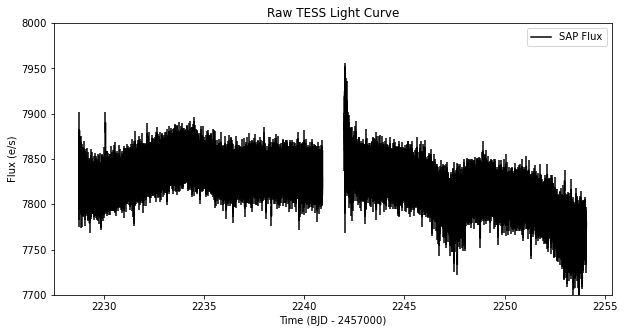

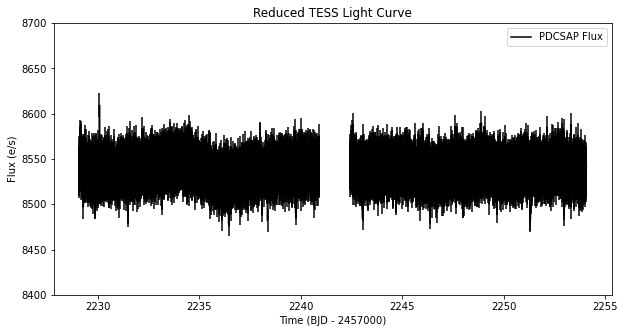

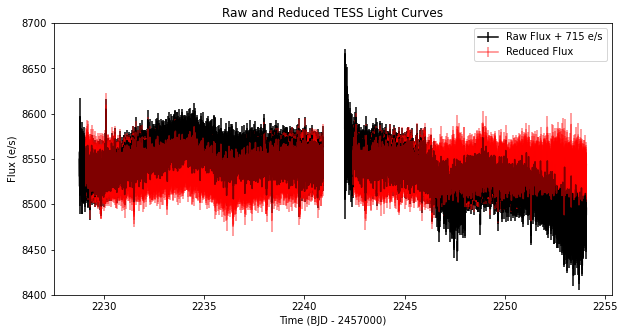

In [45]:
## plot raw flux data (sap_flux)
df.plot(x='TIME', y='SAP_FLUX', yerr='SAP_FLUX_ERR', figsize=(10,5), color='black', label='SAP Flux', title='Raw TESS Light Curve')
plt.ylim(7700, 8000)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot the reduced data (pdcsap_flux)
df.plot(x='TIME', y='PDCSAP_FLUX', yerr='PDCSAP_FLUX_ERR', figsize=(10,5), color='black', label='PDCSAP Flux', title='Reduced TESS Light Curve')
plt.ylim(8400, 8700)
#plt.ylim(0.9*df['SAP_FLUX'].min(), 1.1*df['SAP_FLUX'].max()) ## for consistency of comparison
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.show();

## plot them together, adusting values so they are centered together
raw_mean = df['SAP_FLUX'].mean()
reduced_mean = df['PDCSAP_FLUX'].mean()
mean_diff = reduced_mean - raw_mean
raw_flux_adj = df['SAP_FLUX'] + mean_diff
reduced_flux_adj = df['PDCSAP_FLUX']
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(df['TIME'], raw_flux_adj, yerr = df['SAP_FLUX_ERR'],color='black', label='Raw Flux + {} e/s'.format(round(mean_diff)))
ax.errorbar(df['TIME'], reduced_flux_adj, yerr=df['PDCSAP_FLUX_ERR'], color='red', label='Reduced Flux',alpha=0.5)
plt.ylim(8400, 8700)
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Flux (e/s)');
plt.title('Raw and Reduced TESS Light Curves')
plt.legend();
plt.show();

The "SAP_FLUX" column represents the unreduced lightcurve data, whereas the the "PDCSAP_FLUX" column represents the reduced lightcurve data. We note that the reduced data has an average flux value of roughly 715 $e/s$ higher than the raw lightcurve. One can clearly see that this has significantly fewer outliers. This makes it easier to detect actual transits and the mean flux value will be more representative of the actual baseline. As a result, we will be using the reduced data for our analysis.

2.2 Data Processing 
<a id='processing'></a>  

To make analysis easier, we will be normalizing the data. This will be accomplished by using the equation
$$
\begin{equation}
norm(x) = \frac{x-x_{max}}{x_{max}-x_{min}}
\end{equation}
$$
where $x_{max}$ and $x_{min}$ are the maximum and minimum values, respectively, and $norm(x)$ is the resulting normalized flux value. For the flux error, we determine the scale ratio for each flux point and then apply that same scaling to the corresponding error value. This ensures that the error values are scaled in the same way as the flux values.

Max Flux: 8609.421875 e/s
Mean Flux: 8537.895957709137 e/s
Min Flux: 8478.0234375 e/s

Normalized Flux Max: 1.0
Normalized Flux Mean: 0.4556562570170346
Normalized Flux Min: 0.0


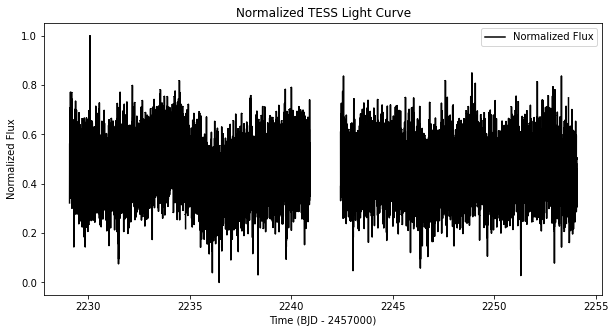

In [46]:
## retreive the flux data and flux error as numpy arrays to process
flux = df['PDCSAP_FLUX'].astype(float)
flux_err = df['PDCSAP_FLUX_ERR'].astype(float)

## find the max and min flux values
max_flux = np.max(flux)
min_flux = np.min(flux)

print('Max Flux: %s e/s'% max_flux)
print('Mean Flux: %s e/s'% np.mean(flux))
print('Min Flux: %s e/s'% min_flux)

## define normalization function and 
norm = lambda x: np.abs((x - np.min(x))/(np.max(x) - np.min(x)))
norm_flux = norm(flux)
#norm_flux_err = norm(flux_err)

## normalize flux error by taking the ratio of the normalized flux to the original flux for each data point
norm_ratio = norm_flux/flux ## will be less than 1
norm_flux_err = norm_ratio*flux_err ## will be less than flux_err


## add normalized flux and flux error to the dataframe
df['NORM_FLUX'] = norm_flux
df['NORM_FLUX_ERR'] = norm_flux_err
norm_flux_mean = df['NORM_FLUX'].mean()

print()
print('Normalized Flux Max: %s'% np.max(norm_flux))
print('Normalized Flux Mean: %s'% norm_flux_mean)
print('Normalized Flux Min: %s'% np.min(norm_flux))


## plot the normalized flux data
df.plot(x='TIME', y='NORM_FLUX', yerr='NORM_FLUX_ERR', figsize=(10,5), color='black', label='Normalized Flux', title='Normalized TESS Light Curve')
plt.xlabel('Time (BJD - 2457000)');
plt.ylabel('Normalized Flux');  
plt.show();

In order to perform data analysis, we need to seperate the transits into individual light curves. In total, there are 14 transits in the data set. These are known values and can be identified by their rough start and end times to then determine the actual transit time. We will use these times to create a list of light curves, each containing the data for a single transit. 

In [47]:
## define function to seperate data into transits and plot them in subplots
transit_times = {
    't01': [2229.7, 2230],
    't02': [2231.3, 2231.7],
    't03': [2233.05, 2233.25],
    't04': [2234.7, 2234.9],
    't05': [2236.35, 2236.55],
    't06': [2238, 2238.2],
    't07': [2239.65, 2239.85],
    't08': [2243, 2243.2],
    't09': [2244.6, 2244.8],
    't10': [2246.2, 2246.6],
    't11': [2247.7, 2248.2],
    't12': [2249.5, 2249.9],
    't13': [2251.2, 2251.6],
    't14': [2252.9, 2253],
}

def transits(df, transit_times, plot=True, save=False):
    '''

    '''

    fig, axs = plt.subplots(3,5, figsize=(10, 20))  

    for key, value in transit_times.items():
        idx=0 ##counter for subplot index
        transit = df.loc[(df['TIME'] > value[0]) & (df['TIME'] < value[1])]
        if plot:
            ax = axs.flatten()[idx]
            transit.plot(x='TIME', y='NORM_FLUX', yerr='NORM_FLUX_ERR', ax=ax, color='black', label=key)
            

        idx+=1


### 3. Analysis
<a id='analysis'></a>

describe the model and what decisions we made in markdown, then do the analysis in python code cells

### 3.1 Sensitivity Analysis
<a id='sensitivity'></a>

### 4. Results
<a id='results'></a>

describe what we found and how we found it in markdown, then show plots and various things in python cells

### 5. Discussion
<a id='discussion'></a>

Maybe describe what we've learned? I'm not sure, this may be uneccessary